# Imports are here


In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb

#import xgboost as xgb
from scipy.sparse import vstack, csr_matrix, save_npz, load_npz
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from scipy import sparse

# Scalers
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
import gc
gc.enable()

import warnings
warnings.filterwarnings("ignore")

import logging

logging.basicConfig(filename='log.txt',level=logging.DEBUG, format='%(asctime)s %(message)s')


In [3]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float32',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float32',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float32',
        'AVProductsEnabled':                                    'float32',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float32',
        'GeoNameIdentifier':                                    'float32',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float32',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float32',
        'IeVerIdentifier':                                      'float32',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float32',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float32',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float32',
        'Census_ProcessorManufacturerIdentifier':               'float32',
        'Census_ProcessorModelIdentifier':                      'float32',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float32',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float32',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float32',
        'Census_IsFlightsDisabled':                             'float32',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float32',
        'Census_FirmwareManufacturerIdentifier':                'float32',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float32',
        'Census_IsVirtualDevice':                               'float32',
        'Census_IsTouchEnabled':                                'int8', # this is used 
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float32',
        'Wdft_IsGamer':                                         'float32',
        'Wdft_RegionIdentifier':                                'float32',
        'HasDetections':                                        'int8'
  }


def reduce_memory_usage(df , verbose=True):
      
      numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] 
      start_memory = df.memory_usage(deep=True).sum() / 1024**2 ;  
      
      for col in df.columns:
            col_type = df[col].dtypes
            
            if (col_type in numerics):
                  c_min = df[col].min() 
                  c_max = df[col].max()
                  
                  if (str(col_type)[:3] == 'int'):
                        if (c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max):
                              df[col] = df[col].astype(np.int8)
                        
                        elif (c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max):
                              df[col] = df[col].astype(np.int16)
                        
                        elif (c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max):
                              df[col] = df[col].astype(np.int32)
                        elif (c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max):
                              df[col] = df[col].astype(np.int64)
                  
                  else:
                        if (c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max):
                              df[col] = df[col].astype(np.float16)
                        
                        elif (c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max):
                              df[col] = df[col].astype(np.float32)
                        else:
                              df[col] = df[col].astype(np.float64)
      
      end_memory = df.memory_usage(deep=True).sum() / 1024**2 
      
      if verbose:
            print("Memory usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)".format(start_memory, end_memory, 100 * (start_memory - end_memory) / start_memory)) ; 
            
      return df



In [4]:
numerics = ['int8' , 'int16' , 'int32' , 'int64'  , 'float32' , 'float64'] ;  

numerical_columns = [c for c,v in dtypes.items() if v in numerics] ;  

categorical_columns = [c for c,v in dtypes.items() if v not in numerics] ; 

# %%time

train = pd.read_csv("../microsoft-malware-prediction/train.csv" , dtype=dtypes) ; 




In [5]:
train = reduce_memory_usage(train) ; 


Memory usage decreased from 2692.26 Mb to 2232.81 Mb (17.1% reduction)


In [6]:
stats = [] ; 
for col in train.columns:
  stats.append((col , train[col].nunique() , train[col].isnull().sum() * 100 / train.shape[0] , train[col].value_counts(normalize=True , dropna=False).values[0] * 100 , train[col].dtype)) ; 
      
stats_dataframe = pd.DataFrame(stats , columns=['Feature' , 'Unique_values' , 'Percentage of missing values' , 'Percentage of values in the biggest category' , 'type']) ; 

stats_dataframe = stats_dataframe.sort_values('Percentage of missing values' , ascending=False) ; 


pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.width', 1000)        # Set width for better display
pd.set_option('display.colheader_justify', 'center')  # Center align the column headers

print(stats_dataframe)

                        Feature                        Unique_values  Percentage of missing values  Percentage of values in the biggest category    type  
28                                            PuaMode           2               99.974119                             99.974119                   category
41                              Census_ProcessorClass           3               99.589407                             99.589407                   category
8                           DefaultBrowsersIdentifier        1730               95.141637                             95.141637                    float16
68                         Census_IsFlightingInternal           2               83.044030                             83.044030                    float16
52                         Census_InternalBatteryType          78               71.046809                             71.046809                   category
71                              Census_ThresholdOptIn           2     

# Some of the things we get to see from here are : 

PuaMode and Census_ProcessorClass have 99%+ missing values, which means that these columns are useless and should be dropped; 

In DefaultBrowsersIdentifier column 95% values belong to one category, so I think this columns is also useless;

Census_IsFlightingInternal is strange, but maybe analysis of it will make sense;

There are 26 columns in total in which one category contains 90% values. I think that these imbalanced columns should be removed from the dataset;



In [7]:
good_columns = list(train.columns) ; 

for col in train.columns:
  rate = train[col].value_counts(normalize=True , dropna=False).values[0] ;
  if (rate > 0.9):
    good_columns.remove(col) ; 


In [8]:
train = train[good_columns] ; 


Reading the test csv now . 

In [9]:
test_dtypes = {k : v for k,v in dtypes.items() if k in good_columns}  ; 

chunk_size = 100000 
chunks = pd.read_csv("../microsoft-malware-prediction/test.csv", dtype=test_dtypes, usecols=good_columns[:-1], chunksize=chunk_size)


test = pd.concat(chunks, ignore_index=True)

test.loc[6529507, 'OsBuildLab'] = '17134.1.amd64fre.rs4_release.180410-1804'
test['OsBuildLab'] = test['OsBuildLab'].fillna('17134.1.amd64fre.rs4_release.180410-1804')
test = reduce_memory_usage(test)

Memory usage decreased from 7758.64 Mb to 7489.02 Mb (3.5% reduction)


In [10]:
train.head()

,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,1.1.15100.1,4.18.1807.18075,1.273.1735.0,53447.0,1.0,29,128035.0,18.0,35.0,-85,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,NaN,Desktop,2668.0,9124.0,4.0,5.0,2340.0,476940.0,HDD,299451.0,4096.0,Desktop,18.906250,1440.0,900.0,Desktop,NaN,4.294967e+09,10.0.17134.165,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,IS_GENUINE,Retail,NaN,NaN,628.0,36144.0,0,NaN,0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,1.1.14600.4,4.13.17134.1,1.263.48.0,53447.0,1.0,93,1482.0,18.0,119.0,64,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,NaN,Notebook,2668.0,91656.0,4.0,5.0,2404.0,476940.0,HDD,102385.0,4096.0,Notebook,13.898438,1366.0,768.0,Mobile,NaN,1.000000e+00,10.0.17134.1,rs4_release,17134,1,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,OFFLINE,Retail,NaN,NaN,628.0,57858.0,0,NaN,0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,1.1.15100.1,4.18.1807.18075,1.273.1341.0,53447.0,1.0,86,153579.0,18.0,64.0,49,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,RequireAdmin,Desktop,4908.0,317701.0,4.0,5.0,1972.0,114473.0,SSD,113907.0,4096.0,Desktop,21.500000,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,rs4_release,17134,165,Core,CORE,UUPUpgrade,7.0,30,FullAuto,IS_GENUINE,OEM:NONSLP,NaN,NaN,142.0,52682.0,0,NaN,0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,1.1.15100.1,4.18.1807.18075,1.273.1527.0,53447.0,1.0,88,20710.0,NaN,117.0,115,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,ExistsNotSet,Desktop,1443.0,275890.0,4.0,5.0,2272.0,238475.0,UNKNOWN,227116.0,4096.0,MiniTower,18.500000,1366.0,768.0,Desktop,NaN,4.294967e+09,10.0.17134.228,rs4_release,17134,228,Professional,PROFESSIONAL,UUPUpgrade,17.0,64,FullAuto,IS_GENUINE,OEM:NONSLP,NaN,NaN,355.0,20050.0,0,NaN,0,0.0,3.0,1
4,000014a5f00daa18e76b81417eeb99fc,1.1.15100.1,4.18.1807.18075,1.273.1379.0,53447.0,1.0,18,37376.0,NaN,277.0,75,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,RequireAdmin,Notebook,1443.0,331929.0,4.0,5.0,2500.0,476940.0,HDD,101900.0,6144.0,Portable,14.000000,1366.0,768.0,Mobile,lion,0.000000e+00,10.0.17134.191,rs4_release,17134,191,Core,CORE,Update,8.0,31,FullAuto,IS_GENUINE,Retail,0.0,0.0,355.0,19844.0,0,0.0,0,0.0,1.0,1


In [11]:
# function to plot data
import plotly.offline as py
import plotly.graph_objs as go

def plot_categorical_feature(col, only_bars=False, top_n=10, by_touch=False):
    top_n = top_n if train[col].nunique() > top_n else train[col].nunique()
    print(f"{col} has {train[col].nunique()} unique values and type: {train[col].dtype}.")
    print(train[col].value_counts(normalize=True, dropna=False).head())
    
    if not by_touch:
        if not only_bars:
            df = train.groupby([col]).agg({'HasDetections': ['count', 'mean']})
            df = df.sort_values(('HasDetections', 'count'), ascending=False).head(top_n).sort_index()
            data = [go.Bar(x=df.index, y=df['HasDetections']['count'].values, name='counts'),
                    go.Scatter(x=df.index, y=df['HasDetections']['mean'], name='Detections rate', yaxis='y2')]

            layout = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories and mean target value",
                                xaxis = dict(title = f'{col}',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                yaxis = dict(title = 'Counts',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                yaxis2=dict(title='Detections rate', overlaying='y', side='right')),
                           legend=dict(orientation="v"))

        else:
            top_cat = list(train[col].value_counts(dropna=False).index[:top_n])
            df0 = train.loc[(train[col].isin(top_cat)) & (train['HasDetections'] == 1), col].value_counts().head(10).sort_index()
            df1 = train.loc[(train[col].isin(top_cat)) & (train['HasDetections'] == 0), col].value_counts().head(10).sort_index()
            data = [go.Bar(x=df0.index, y=df0.values, name='Has Detections'),
                    go.Bar(x=df1.index, y=df1.values, name='No Detections')]

            layout = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories",
                                xaxis = dict(title = f'{col}',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                yaxis = dict(title = 'Counts',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                ),
                           legend=dict(orientation="v"), barmode='group')
        
        py.iplot(dict(data=data, layout=layout))
        
    else:
        top_n = 10
        top_cat = list(train[col].value_counts(dropna=False).index[:top_n])
        df = train.loc[train[col].isin(top_cat)]

        df1 = train.loc[train['Census_IsTouchEnabled'] == 1]
        df0 = train.loc[train['Census_IsTouchEnabled'] == 0]

        df0_ = df0.groupby([col]).agg({'HasDetections': ['count', 'mean']})
        df0_ = df0_.sort_values(('HasDetections', 'count'), ascending=False).head(top_n).sort_index()
        df1_ = df1.groupby([col]).agg({'HasDetections': ['count', 'mean']})
        df1_ = df1_.sort_values(('HasDetections', 'count'), ascending=False).head(top_n).sort_index()
        data1 = [go.Bar(x=df0_.index, y=df0_['HasDetections']['count'].values, name='Nontouch device counts'),
                go.Scatter(x=df0_.index, y=df0_['HasDetections']['mean'], name='Detections rate for nontouch devices', yaxis='y2')]
        data2 = [go.Bar(x=df1_.index, y=df1_['HasDetections']['count'].values, name='Touch device counts'),
                go.Scatter(x=df1_.index, y=df1_['HasDetections']['mean'], name='Detections rate for touch devices', yaxis='y2')]

        layout = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories for nontouch devices",
                            xaxis = dict(title = f'{col}',
                                         showgrid=False,
                                         zeroline=False,
                                         showline=False,
                                         type='category'),
                            yaxis = dict(title = 'Counts',
                                         showgrid=False,
                                         zeroline=False,
                                         showline=False,),
                                    yaxis2=dict(title='Detections rate', overlaying='y', side='right'),
                            ),
                       legend=dict(orientation="v"), barmode='group')

        py.iplot(dict(data=data1, layout=layout))
        layout['title'] = f"Counts of {col} by top-{top_n} categories for touch devices"
        py.iplot(dict(data=data2, layout=layout))

In [12]:
train['HasDetections'].value_counts()

# to check the count of the target variable


HasDetections
0    4462591
1    4458892
Name: count, dtype: int64

The target is balanced, which is nice.

Census_IsTouchEnabled 

In [13]:
plot_categorical_feature('Census_IsTouchEnabled' , True) ;  


Census_IsTouchEnabled has 2 unique values and type: int8.
Census_IsTouchEnabled
0    0.874457
1    0.125543
Name: proportion, dtype: float64


As expected Microsoft has much more computers that touch devices. The rate of infections is lower for touch devices, but not by much.



# Variables with high amount of unique values 

At first we will look at variables with lot of categories . Then we will move to variables with limited amount of categories .

EngineVersion 

In [14]:
plot_categorical_feature('EngineVersion', by_touch=True)


EngineVersion has 70 unique values and type: category.
EngineVersion
1.1.15200.1    0.430990
1.1.15100.1    0.412030
1.1.15000.2    0.029728
1.1.14901.4    0.023809
1.1.14600.4    0.018000
Name: proportion, dtype: float64


We can see that two categories take 84% of all values. The difference in detection rates is noticable. Other categories have different detection rate, but it is simply due to the low number of samples in them. Patterns for touch and non-touch devices are quite similar.

AppVersion

In [15]:
plot_categorical_feature('AppVersion')

AppVersion has 110 unique values and type: category.
AppVersion
4.18.1807.18075    0.576050
4.18.1806.18062    0.095380
4.12.16299.15      0.040338
4.10.209.0         0.030539
4.13.17134.1       0.028837
Name: proportion, dtype: float64


In this case we have one main category with 0.53 detection rate, other categories are much smaller

AvSigVersion

In [16]:
plot_categorical_feature("AvSigVersion")

AvSigVersion has 8531 unique values and type: category.
AvSigVersion
1.273.1420.0    0.011469
1.263.48.0      0.010987
1.275.1140.0    0.010899
1.275.727.0     0.010362
1.273.371.0     0.009748
Name: proportion, dtype: float64


This feature has a huge amount of categories, it seems this is a version of an often updated software.

AVProductStatesIdentifier -  ID for the specific configuration of a user's antivirus software



In [17]:
plot_categorical_feature('AVProductStatesIdentifier', True, 10)

AVProductStatesIdentifier has 28970 unique values and type: float32.
AVProductStatesIdentifier
53447.0    0.652870
7945.0     0.053343
47238.0    0.036727
62773.0    0.029901
46413.0    0.012652
Name: proportion, dtype: float64


We get to know from here that it is a categorical feature . We change the data as per this then .  

In [18]:
train['AVProductStatesIdentifier'] = train['AVProductStatesIdentifier'].astype('category')
test['AVProductStatesIdentifier'] = test['AVProductStatesIdentifier'].astype('category')

AVProductsInstalled

In [19]:
plot_categorical_feature('AVProductsInstalled', True)

AVProductsInstalled has 8 unique values and type: float16.
AVProductsInstalled
1.0    0.695949
2.0    0.275628
3.0    0.023326
NaN    0.004060
4.0    0.000982
Name: proportion, dtype: float64


Interestingly , If a computer has an antivirus, it is less likely to be infected. But having two antiviruses has an opposite effect. Maybe those who install 2 antiviruses tend to have less experience with working on PC? Also other categories have really low samples, let's combine them.

In [20]:
train['AVProductsInstalled'] = train['AVProductsInstalled'].astype('float32')
test['AVProductsInstalled'] = test['AVProductsInstalled'].astype('float32')

train['AVProductsInstalled'] = train['AVProductsInstalled'].astype('category')
test['AVProductsInstalled'] = test['AVProductsInstalled'].astype('category')


In [21]:
plot_categorical_feature('AVProductsInstalled', True, by_touch=True)

AVProductsInstalled has 8 unique values and type: category.
AVProductsInstalled
 1.0    0.695949
 2.0    0.275628
 3.0    0.023326
NaN     0.004060
 4.0    0.000982
Name: proportion, dtype: float64


It is interesting, that even on touch devices people sometimes install 2 antiviruses.



CountryIdentifier - ID for the country the machine is located in


In [22]:
plot_categorical_feature('CountryIdentifier', True, 20)


CountryIdentifier has 222 unique values and type: int16.
CountryIdentifier
43     0.044519
29     0.039006
141    0.037372
93     0.031791
171    0.031449
Name: proportion, dtype: float64


Once again we have a categorical column which was defined as numerical. While most countries have rate of detections ~50%, there are some countries where there are much more infected devices

In [23]:
train['CountryIdentifier'] = train['CountryIdentifier'].astype('category')
test['CountryIdentifier'] = test['CountryIdentifier'].astype('category')

CityIdentifier - The same situation for cities.



In [24]:
plot_categorical_feature('CityIdentifier', True, 20)


CityIdentifier has 107366 unique values and type: float32.
CityIdentifier
NaN         0.036475
130775.0    0.010627
16668.0     0.009503
82373.0     0.009338
10222.0     0.008050
Name: proportion, dtype: float64


In [25]:
train['CityIdentifier'] = train['CityIdentifier'].astype('category')
test['CityIdentifier'] = test['CityIdentifier'].astype('category')

OrganizationIdentifier

In [26]:
plot_categorical_feature('OrganizationIdentifier', True)


OrganizationIdentifier has 49 unique values and type: float16.
OrganizationIdentifier
27.0    0.470377
NaN     0.308415
18.0    0.197745
48.0    0.007156
50.0    0.005100
Name: proportion, dtype: float64


This is quuite strange. 2 organizations cover ~66% of all computers, while unknown organizations have 30% more. Maybe these are some specific industries? Let's combine values.

In [27]:
train['OrganizationIdentifier'] = train['OrganizationIdentifier'].astype('float32')
test['OrganizationIdentifier'] = test['OrganizationIdentifier'].astype('float32')

train['OrganizationIdentifier'] = train['OrganizationIdentifier'].astype('category')
test['OrganizationIdentifier'] = test['OrganizationIdentifier'].astype('category')


In [28]:
plot_categorical_feature('OrganizationIdentifier', True, by_touch=True)

OrganizationIdentifier has 49 unique values and type: category.
OrganizationIdentifier
 27.0    0.470377
NaN      0.308415
 18.0    0.197745
 48.0    0.007156
 50.0    0.005100
Name: proportion, dtype: float64


GeoNameIdentifier

In [29]:
plot_categorical_feature('GeoNameIdentifier', True)


GeoNameIdentifier has 292 unique values and type: float16.
GeoNameIdentifier
277.0    0.171712
211.0    0.047432
53.0     0.045823
89.0     0.040441
240.0    0.038846
Name: proportion, dtype: float64


This is also categorical , change the type . 

In [30]:
train['GeoNameIdentifier'] = train['GeoNameIdentifier'].astype('float32')
test['GeoNameIdentifier'] = test['GeoNameIdentifier'].astype('float32') 
 
train['GeoNameIdentifier'] = train['GeoNameIdentifier'].astype('category')
test['GeoNameIdentifier'] = test['GeoNameIdentifier'].astype('category')

LocaleEnglishNameIdentifier

In [31]:
plot_categorical_feature('LocaleEnglishNameIdentifier', True)

LocaleEnglishNameIdentifier has 252 unique values and type: int8.
LocaleEnglishNameIdentifier
 75    0.234780
-74    0.050450
 74    0.046075
 42    0.045913
 88    0.042058
Name: proportion, dtype: float64


Same with this 

In [32]:
train['LocaleEnglishNameIdentifier'] = train['LocaleEnglishNameIdentifier'].astype('category')
test['LocaleEnglishNameIdentifier'] = test['LocaleEnglishNameIdentifier'].astype('category')

OsPlatformSubRelease - Returns the OS Platform sub-release (Windows Vista, Windows 7, Windows 8, TH1, TH2)

In [33]:
plot_categorical_feature('OsPlatformSubRelease', True, by_touch=True)


OsPlatformSubRelease has 9 unique values and type: category.
OsPlatformSubRelease
rs4    0.438887
rs3    0.280635
rs2    0.087460
rs1    0.081917
th2    0.046136
Name: proportion, dtype: float64


It is interesting that most computers have Windows 10 (rs*). I suppose Microsoft specifically chose them, so that we would work with modern devices?

OsBuildLab - Build lab that generated the current OS. Example: 9600.17630.amd64fre.winblue_r7.150109-2022

In [34]:
plot_categorical_feature('OsBuildLab', True)


OsBuildLab has 663 unique values and type: category.
OsBuildLab
17134.1.amd64fre.rs4_release.180410-1804                 0.410044
16299.431.amd64fre.rs3_release_svc_escrow.180502-1908    0.140411
16299.15.amd64fre.rs3_release.170928-1534                0.107724
15063.0.amd64fre.rs2_release.170317-1834                 0.080484
17134.1.x86fre.rs4_release.180410-1804                   0.028815
Name: proportion, dtype: float64


IeVerIdentifier

In [35]:
plot_categorical_feature('IeVerIdentifier', True)


IeVerIdentifier has 303 unique values and type: float16.
IeVerIdentifier
137.0    0.435560
117.0    0.198166
108.0    0.053174
111.0    0.052438
98.0     0.039726
Name: proportion, dtype: float64


In [36]:
train['IeVerIdentifier'] = train['IeVerIdentifier'].astype('float32')
test['IeVerIdentifier'] = test['IeVerIdentifier'].astype('float32')

train['IeVerIdentifier'] = train['IeVerIdentifier'].astype('category')
test['IeVerIdentifier'] = test['IeVerIdentifier'].astype('category')

Census_OEMNameIdentifier

In [37]:
plot_categorical_feature('Census_OEMNameIdentifier', True)


Census_OEMNameIdentifier has 2564 unique values and type: float16.
Census_OEMNameIdentifier
2668.0    0.144289
2102.0    0.116412
1443.0    0.106432
2206.0    0.103609
585.0     0.100370
Name: proportion, dtype: float64


In [38]:
train['Census_OEMNameIdentifier'] = train['Census_OEMNameIdentifier'].astype('float32')
test['Census_OEMNameIdentifier'] = test['Census_OEMNameIdentifier'].astype('float32')

train['Census_OEMNameIdentifier'] = train['Census_OEMNameIdentifier'].astype('category')
test['Census_OEMNameIdentifier'] = test['Census_OEMNameIdentifier'].astype('category')

Census_OEMModelIdentifier

In [39]:
plot_categorical_feature('Census_OEMModelIdentifier', True)


Census_OEMModelIdentifier has 175365 unique values and type: float32.
Census_OEMModelIdentifier
313586.0    0.034163
242491.0    0.029522
317701.0    0.015584
317708.0    0.012919
NaN         0.011459
Name: proportion, dtype: float64


In [40]:
train['Census_OEMModelIdentifier'] = train['Census_OEMModelIdentifier'].astype('category')
test['Census_OEMModelIdentifier'] = test['Census_OEMModelIdentifier'].astype('category')

In [41]:
# plot_categorical_feature('Census_OEMModelIdentifier', by_touch=True)


Census_ProcessorCoreCount

In [42]:
train['Census_ProcessorCoreCount'] = train['Census_ProcessorCoreCount'].astype('float32')
test['Census_ProcessorCoreCount'] = test['Census_ProcessorCoreCount'].astype('float32')
plot_categorical_feature('Census_ProcessorCoreCount', True, by_touch=True)


Census_ProcessorCoreCount has 45 unique values and type: float32.
Census_ProcessorCoreCount
4.0     0.608665
2.0     0.259146
8.0     0.096957
12.0    0.010391
1.0     0.007890
Name: proportion, dtype: float64


Most computers have 2, 4 or 8 cores. For touch deviced 4 cores are much more common than other configurations. And these 3 variants cover 95% of all samples,

Census_ProcessorModelIdentifier

In [43]:
plot_categorical_feature('Census_ProcessorModelIdentifier', True)


Census_ProcessorModelIdentifier has 2583 unique values and type: float16.
Census_ProcessorModelIdentifier
2696.0    0.032426
1998.0    0.029972
2660.0    0.021940
2372.0    0.019662
1992.0    0.019249
Name: proportion, dtype: float64


In [44]:
train['Census_ProcessorModelIdentifier'] = train['Census_ProcessorModelIdentifier'].astype('float32')
test['Census_ProcessorModelIdentifier'] = test['Census_ProcessorModelIdentifier'].astype('float32')

train['Census_ProcessorModelIdentifier'] = train['Census_ProcessorModelIdentifier'].astype('category')
test['Census_ProcessorModelIdentifier'] = test['Census_ProcessorModelIdentifier'].astype('category')

Census_PrimaryDiskTotalCapacity

In [45]:
plot_categorical_feature('Census_PrimaryDiskTotalCapacity', True)


Census_PrimaryDiskTotalCapacity has 5735 unique values and type: float32.
Census_PrimaryDiskTotalCapacity
476940.0    0.318504
953869.0    0.243881
305245.0    0.053199
122104.0    0.052576
244198.0    0.050696
Name: proportion, dtype: float64


Census_SystemVolumeTotalCapacity

In [46]:
plot_categorical_feature('Census_SystemVolumeTotalCapacity', True)


Census_SystemVolumeTotalCapacity has 536848 unique values and type: float32.
Census_SystemVolumeTotalCapacity
NaN         0.005941
28542.0     0.005828
926992.0    0.005653
476389.0    0.004981
953253.0    0.004660
Name: proportion, dtype: float64


I think that this is a first truly numerical variable. Census_PrimaryDiskTotalCapacity could be numerical, but it has too little unique values and every category could be considered a separate disk model.



Census_TotalPhysicalRAM

In [47]:
plot_categorical_feature('Census_TotalPhysicalRAM', True, by_touch=True)


Census_TotalPhysicalRAM has 3446 unique values and type: float32.
Census_TotalPhysicalRAM
4096.0     0.458950
8192.0     0.246204
2048.0     0.123015
16384.0    0.059582
6144.0     0.044687
Name: proportion, dtype: float64


Quite interesting that most computers have <=8 Gb RAM.

Census_InternalPrimaryDiagonalDisplaySizeInInches

In [48]:
train['Census_InternalPrimaryDiagonalDisplaySizeInInches'] = train['Census_InternalPrimaryDiagonalDisplaySizeInInches'].astype('float32')
test['Census_InternalPrimaryDiagonalDisplaySizeInInches'] = test['Census_InternalPrimaryDiagonalDisplaySizeInInches'].astype('float32')


plot_categorical_feature('Census_InternalPrimaryDiagonalDisplaySizeInInches', True, by_touch=True)

Census_InternalPrimaryDiagonalDisplaySizeInInches has 785 unique values and type: float32.
Census_InternalPrimaryDiagonalDisplaySizeInInches
15.500000    0.341583
13.898438    0.106717
14.000000    0.060803
11.601562    0.035799
21.500000    0.030862
Name: proportion, dtype: float64


I'm really surprised that most computers have 15 inch screens. And this is a rare situation, when for some categories detection rate on PC is higher than on touch devices.

Census_InternalPrimaryDisplayResolutionHorizontal

In [49]:
train['Census_InternalPrimaryDisplayResolutionHorizontal'] = train['Census_InternalPrimaryDisplayResolutionHorizontal'].astype('float32')
test['Census_InternalPrimaryDisplayResolutionHorizontal'] = test['Census_InternalPrimaryDisplayResolutionHorizontal'].astype('float32')

plot_categorical_feature('Census_InternalPrimaryDisplayResolutionHorizontal', True, by_touch=True)

Census_InternalPrimaryDisplayResolutionHorizontal has 2050 unique values and type: float32.
Census_InternalPrimaryDisplayResolutionHorizontal
1366.0    0.506089
1920.0    0.248910
1280.0    0.059119
1600.0    0.056189
1024.0    0.038404
Name: proportion, dtype: float64


Census_InternalPrimaryDisplayResolutionVertical

In [50]:
train['Census_InternalPrimaryDisplayResolutionVertical'] = train['Census_InternalPrimaryDisplayResolutionVertical'].astype('float32')
test['Census_InternalPrimaryDisplayResolutionVertical'] = test['Census_InternalPrimaryDisplayResolutionVertical'].astype('float32')

plot_categorical_feature('Census_InternalPrimaryDisplayResolutionVertical', True, by_touch=True)


Census_InternalPrimaryDisplayResolutionVertical has 1552 unique values and type: float32.
Census_InternalPrimaryDisplayResolutionVertical
768.0     0.557488
1080.0    0.240812
900.0     0.073436
800.0     0.029374
1024.0    0.020885
Name: proportion, dtype: float64


Census_InternalBatteryNumberOfCharges

In [51]:
plot_categorical_feature('Census_InternalBatteryNumberOfCharges', True, by_touch=True)


Census_InternalBatteryNumberOfCharges has 41087 unique values and type: float32.
Census_InternalBatteryNumberOfCharges
0.000000e+00    0.566431
4.294967e+09    0.253769
NaN             0.030124
1.000000e+00    0.006032
2.000000e+00    0.003153
Name: proportion, dtype: float64


Interesting and somewhat strange results. It is expected that most PCs have 0 charges. 4.294967e+09 seems to be some kind of technical value. But having several charges for PC is strange. Anyway, this is definitely a categorical variable

In [52]:
train['Census_InternalBatteryNumberOfCharges'] = train['Census_InternalBatteryNumberOfCharges'].astype('category')
test['Census_InternalBatteryNumberOfCharges'] = test['Census_InternalBatteryNumberOfCharges'].astype('category')

Census_OSVersion

In [53]:
plot_categorical_feature('Census_OSVersion', True)


Census_OSVersion has 469 unique values and type: category.
Census_OSVersion
10.0.17134.228    0.158452
10.0.17134.165    0.100848
10.0.16299.431    0.061262
10.0.17134.285    0.052713
10.0.16299.547    0.038878
Name: proportion, dtype: float64


Census_OSBranch

In [54]:
plot_categorical_feature('Census_OSBranch', True)

Census_OSBranch has 32 unique values and type: category.
Census_OSBranch
rs4_release               0.449382
rs3_release               0.138690
rs3_release_svc_escrow    0.134481
rs2_release               0.089342
rs1_release               0.088050
Name: proportion, dtype: float64


Census_OSBuildNumber

In [55]:
plot_categorical_feature('Census_OSBuildNumber', True)


Census_OSBuildNumber has 165 unique values and type: int16.
Census_OSBuildNumber
17134    0.449351
16299    0.273861
15063    0.089340
14393    0.088040
10586    0.066528
Name: proportion, dtype: float64


In [56]:
train['Census_OSBuildNumber'] = train['Census_OSBuildNumber'].astype('category')
test['Census_OSBuildNumber'] = test['Census_OSBuildNumber'].astype('category')

Census_OSBuildRevision

In [57]:
plot_categorical_feature('Census_OSBuildRevision', True)


Census_OSBuildRevision has 285 unique values and type: int32.
Census_OSBuildRevision
228    0.158453
165    0.100848
431    0.061262
285    0.052713
547    0.038878
Name: proportion, dtype: float64


In [58]:
train['Census_OSBuildRevision'] = train['Census_OSBuildRevision'].astype('category')
test['Census_OSBuildRevision'] = test['Census_OSBuildRevision'].astype('category')

Census_FirmwareManufacturerIdentifier

In [59]:
plot_categorical_feature('Census_FirmwareManufacturerIdentifier', True)


Census_FirmwareManufacturerIdentifier has 712 unique values and type: float16.
Census_FirmwareManufacturerIdentifier
142.0    0.302537
628.0    0.137773
554.0    0.131720
355.0    0.105565
556.0    0.089731
Name: proportion, dtype: float64


In [60]:
train['Census_FirmwareManufacturerIdentifier'] = train['Census_FirmwareManufacturerIdentifier'].astype('float32')
test['Census_FirmwareManufacturerIdentifier'] = test['Census_FirmwareManufacturerIdentifier'].astype('float32')

train['Census_FirmwareManufacturerIdentifier'] = train['Census_FirmwareManufacturerIdentifier'].astype('category')
test['Census_FirmwareManufacturerIdentifier'] = test['Census_FirmwareManufacturerIdentifier'].astype('category')

Census_FirmwareVersionIdentifier

In [61]:
plot_categorical_feature('Census_FirmwareVersionIdentifier', True)


Census_FirmwareVersionIdentifier has 50494 unique values and type: float32.
Census_FirmwareVersionIdentifier
NaN        0.017949
33105.0    0.010044
33111.0    0.006903
33054.0    0.006347
33108.0    0.006169
Name: proportion, dtype: float64


In [62]:
train['Census_FirmwareVersionIdentifier'] = train['Census_FirmwareVersionIdentifier'].astype('category')
test['Census_FirmwareVersionIdentifier'] = test['Census_FirmwareVersionIdentifier'].astype('category')

OsBuild

In [63]:
plot_categorical_feature('OsBuild', True)


OsBuild has 76 unique values and type: int16.
OsBuild
17134    0.438887
16299    0.280635
15063    0.087460
14393    0.081917
10586    0.046136
Name: proportion, dtype: float64


In [64]:
train['OsBuild'] = train['OsBuild'].astype('category')
test['OsBuild'] = test['OsBuild'].astype('category')

Census_ChassisTypeName

In [65]:
plot_categorical_feature('Census_ChassisTypeName', True, by_touch=True)


Census_ChassisTypeName has 52 unique values and type: category.
Census_ChassisTypeName
Notebook    0.588334
Desktop     0.209845
Laptop      0.076846
Portable    0.040453
AllinOne    0.022899
Name: proportion, dtype: float64


Census_InternalBatteryType

In [66]:
def group_battery(x):
    # Check if x is a string before applying .lower()
    if isinstance(x, str):
        x = x.lower()
        if 'li' in x:
            return 1
        else:
            return 0
    else:
        # Handle non-string cases (e.g., integers, NaN)
        return 0

# Apply the function to the columns
train['Census_InternalBatteryType'] = train['Census_InternalBatteryType'].apply(group_battery)
test['Census_InternalBatteryType'] = test['Census_InternalBatteryType'].apply(group_battery)

In [67]:
plot_categorical_feature('Census_InternalBatteryType', True)


Census_InternalBatteryType has 2 unique values and type: float64.
Census_InternalBatteryType
NaN    0.710468
1.0    0.267222
0.0    0.022310
Name: proportion, dtype: float64


Census_OSEdition

We will combine similar versions into one.



In [68]:
def rename_edition(x):
    x = x.lower()
    if 'core' in x:
        return 'Core'
    elif 'pro' in x:
        return 'pro'
    elif 'enterprise' in x:
        return 'Enterprise'
    elif 'server' in x:
        return 'Server'
    elif 'home' in x:
        return 'Home'
    elif 'education' in x:
        return 'Education'
    elif 'cloud' in x:
        return 'Cloud'
    else:
        return x

In [69]:
train['Census_OSEdition'] = train['Census_OSEdition'].astype(str)
test['Census_OSEdition'] = test['Census_OSEdition'].astype(str)
train['Census_OSEdition'] = train['Census_OSEdition'].apply(rename_edition)
test['Census_OSEdition'] = test['Census_OSEdition'].apply(rename_edition)
train['Census_OSEdition'] = train['Census_OSEdition'].astype('category')
test['Census_OSEdition'] = test['Census_OSEdition'].astype('category')

In [70]:
plot_categorical_feature('Census_OSEdition', True, by_touch=True)


Census_OSEdition has 8 unique values and type: category.
Census_OSEdition
Core          0.626167
pro           0.360472
Enterprise    0.006373
Education     0.004667
Server        0.001615
Name: proportion, dtype: float64


Census_OSSkuName

Almost the same as previous variable



In [71]:
train['Census_OSSkuName'] = train['Census_OSSkuName'].astype(str)
test['Census_OSSkuName'] = test['Census_OSSkuName'].astype(str)
train['Census_OSSkuName'] = train['Census_OSSkuName'].apply(rename_edition)
test['Census_OSSkuName'] = test['Census_OSSkuName'].apply(rename_edition)
train['Census_OSSkuName'] = train['Census_OSSkuName'].astype('category')
test['Census_OSSkuName'] = test['Census_OSSkuName'].astype('category')

In [72]:
plot_categorical_feature('Census_OSSkuName', True, by_touch=True)


Census_OSSkuName has 10 unique values and type: category.
Census_OSSkuName
Core          0.626093
pro           0.360543
Enterprise    0.006374
Education     0.004680
Server        0.001616
Name: proportion, dtype: float64


Census_OSInstallLanguageIdentifier

In [75]:
plot_categorical_feature('Census_OSInstallLanguageIdentifier', True)

Census_OSInstallLanguageIdentifier has 39 unique values and type: float16.
Census_OSInstallLanguageIdentifier
8.0     0.356360
9.0     0.115923
7.0     0.057474
29.0    0.055178
14.0    0.048479
Name: proportion, dtype: float64


In [76]:
train['Census_OSInstallLanguageIdentifier'] = train['Census_OSInstallLanguageIdentifier'].astype('float32')
test['Census_OSInstallLanguageIdentifier'] = test['Census_OSInstallLanguageIdentifier'].astype('float32')

train['Census_OSInstallLanguageIdentifier'] = train['Census_OSInstallLanguageIdentifier'].astype('category')
test['Census_OSInstallLanguageIdentifier'] = test['Census_OSInstallLanguageIdentifier'].astype('category')

Census_OSUILocaleIdentifier

In [77]:
plot_categorical_feature('Census_OSUILocaleIdentifier', True)


Census_OSUILocaleIdentifier has 147 unique values and type: int16.
Census_OSUILocaleIdentifier
31     0.355414
34     0.116577
30     0.057613
125    0.055847
49     0.048948
Name: proportion, dtype: float64


In [78]:
train['Census_OSUILocaleIdentifier'] = train['Census_OSUILocaleIdentifier'].astype('category')
test['Census_OSUILocaleIdentifier'] = test['Census_OSUILocaleIdentifier'].astype('category')

Census_OSUILocaleIdentifier

In [79]:
plot_categorical_feature('Census_OSUILocaleIdentifier', True)


Census_OSUILocaleIdentifier has 147 unique values and type: category.
Census_OSUILocaleIdentifier
31     0.355414
34     0.116577
30     0.057613
125    0.055847
49     0.048948
Name: proportion, dtype: float64


Changed the above to category  . 

OsSuite

In [80]:
plot_categorical_feature('OsSuite', True)


OsSuite has 14 unique values and type: int16.
OsSuite
768    0.623289
256    0.375078
272    0.001355
400    0.000089
16     0.000082
Name: proportion, dtype: float64


In [81]:
train['OsSuite'] = train['OsSuite'].astype('category')
test['OsSuite'] = test['OsSuite'].astype('category')

Wdft_RegionIdentifier

In [82]:
plot_categorical_feature('Wdft_RegionIdentifier', True)


Wdft_RegionIdentifier has 15 unique values and type: float16.
Wdft_RegionIdentifier
10.0    0.201772
11.0    0.151077
3.0     0.145255
1.0     0.138123
15.0    0.114061
Name: proportion, dtype: float64


In [84]:
train['Wdft_RegionIdentifier'] = train['Wdft_RegionIdentifier'].astype('float32')
test['Wdft_RegionIdentifier'] = test['Wdft_RegionIdentifier'].astype('float32')


train['Wdft_RegionIdentifier'] = train['Wdft_RegionIdentifier'].astype('category')
test['Wdft_RegionIdentifier'] = test['Wdft_RegionIdentifier'].astype('category')

SkuEdition

In [85]:
train['SkuEdition'].value_counts(dropna=False, normalize=True)


SkuEdition
Home               0.618097
Pro                0.361393
Invalid            0.008749
Education          0.004561
Enterprise         0.003851
Enterprise LTSB    0.002320
Cloud              0.000626
Server             0.000402
Name: proportion, dtype: float64

Home and Pro editions together give 97.9%+ of all values. Condidering that other categories are for Enterprise mostly, I combine them with Pro.

In [86]:
pd.crosstab(train['SkuEdition'], train['Census_OSEdition'], normalize='columns')


Census_OSEdition,Cloud,Core,Education,Enterprise,Home,Server,pro,ultimate
SkuEdition,,,,,,,,
Cloud,0.888429,7.160321e-07,0.000000,0.000000,0.000000,0.000000,9.328509e-07,0.0
Education,0.000000,1.521568e-05,0.966952,0.000000,0.000000,0.000000,1.085217e-04,0.0
Enterprise,0.000000,2.148096e-06,0.000024,0.603117,0.000000,0.000139,1.648037e-05,0.0
Enterprise LTSB,0.000000,5.370240e-07,0.000048,0.363763,0.000000,0.000000,4.975205e-06,0.0
Home,0.001751,9.860368e-01,0.003843,0.001706,0.166667,0.000416,1.780812e-03,0.0
Invalid,0.000000,8.670432e-03,0.000360,0.000000,0.166667,0.748525,5.849286e-03,1.0
Pro,0.109820,5.274113e-03,0.028773,0.031379,0.666667,0.002498,9.922390e-01,0.0
Server,0.000000,0.000000e+00,0.000000,0.000035,0.000000,0.248421,0.000000e+00,0.0


It seems that Home Sku edition corresponds to Core OS Edition, and Pro Sku edition corresponts to all other OS editions.



In [87]:
train['SmartScreen'].value_counts(dropna=False, normalize=True).cumsum()


SmartScreen
RequireAdmin    0.483797
NaN             0.839905
ExistsNotSet    0.957170
Off             0.978081
Warn            0.993267
Prompt          0.997138
Block           0.999663
off             0.999815
On              0.999897
&#x02;          0.999943
&#x01;          0.999981
on              0.999997
requireadmin    0.999998
OFF             0.999999
0               0.999999
Promt           0.999999
Enabled         0.999999
prompt          1.000000
warn            1.000000
00000000        1.000000
requireAdmin    1.000000
&#x03;          1.000000
Name: proportion, dtype: float64

As per description: If the value exists but is blank, the value "ExistsNotSet" is sent in telemetry. So missing values and ExistsNotSet are in fact the same. This category + RequireAdmin + Off + Warn are 99.3% of all values. I'll combine all other values into Prompt.

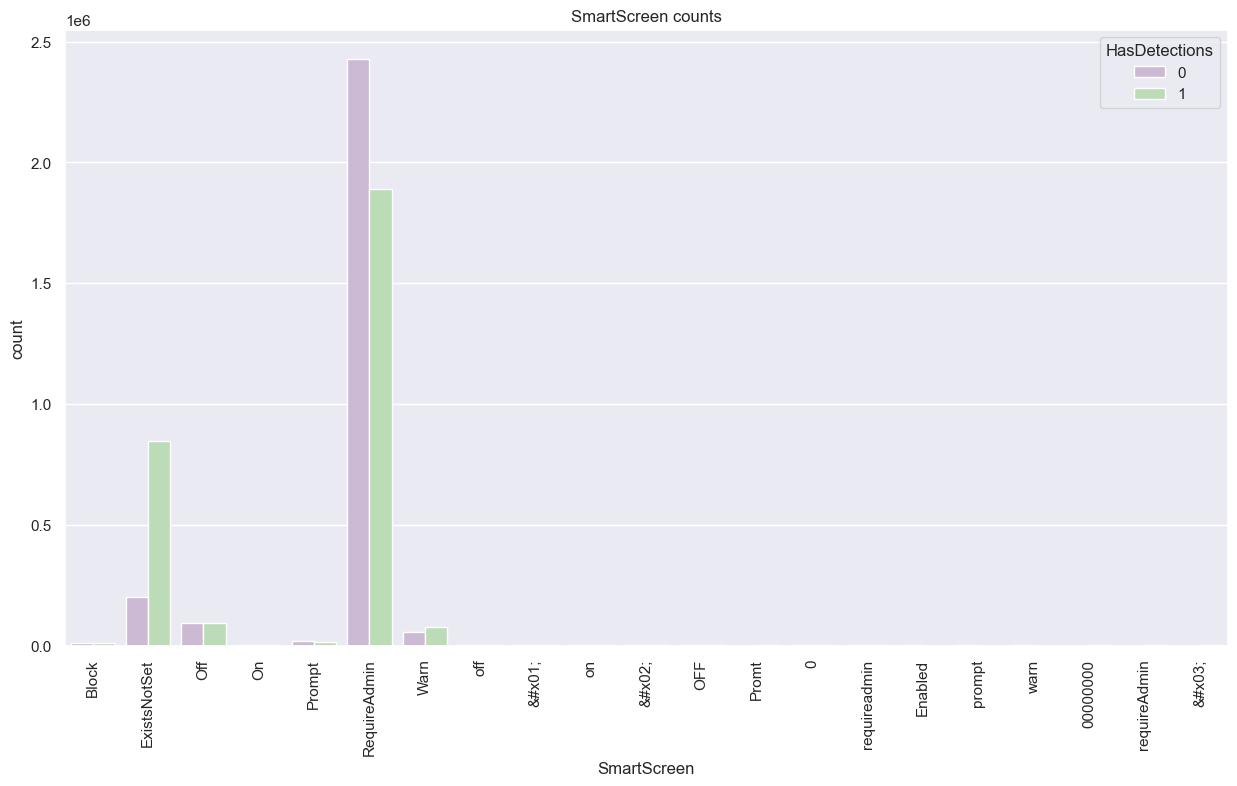

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(15, 8)})
sns.countplot(x="SmartScreen", hue="HasDetections",  palette="PRGn", data=train)
plt.title("SmartScreen counts")
plt.xticks(rotation='vertical')
plt.show()

Census_MDC2FormFactor

In [90]:
train['Census_MDC2FormFactor'].value_counts(dropna=False, normalize=True).cumsum()


Census_MDC2FormFactor
Notebook        0.641521
Desktop         0.860216
Convertible     0.905655
Detachable      0.939083
AllInOne        0.971822
PCOther         0.987509
LargeTablet     0.995033
SmallTablet     0.998552
SmallServer     0.999519
MediumServer    0.999898
LargeServer     0.999997
ServerOther     1.000000
IoTOther        1.000000
Name: proportion, dtype: float64

In [91]:
plot_categorical_feature('Census_MDC2FormFactor', True)


Census_MDC2FormFactor has 13 unique values and type: category.
Census_MDC2FormFactor
Notebook       0.641521
Desktop        0.218695
Convertible    0.045438
Detachable     0.033429
AllInOne       0.032739
Name: proportion, dtype: float64


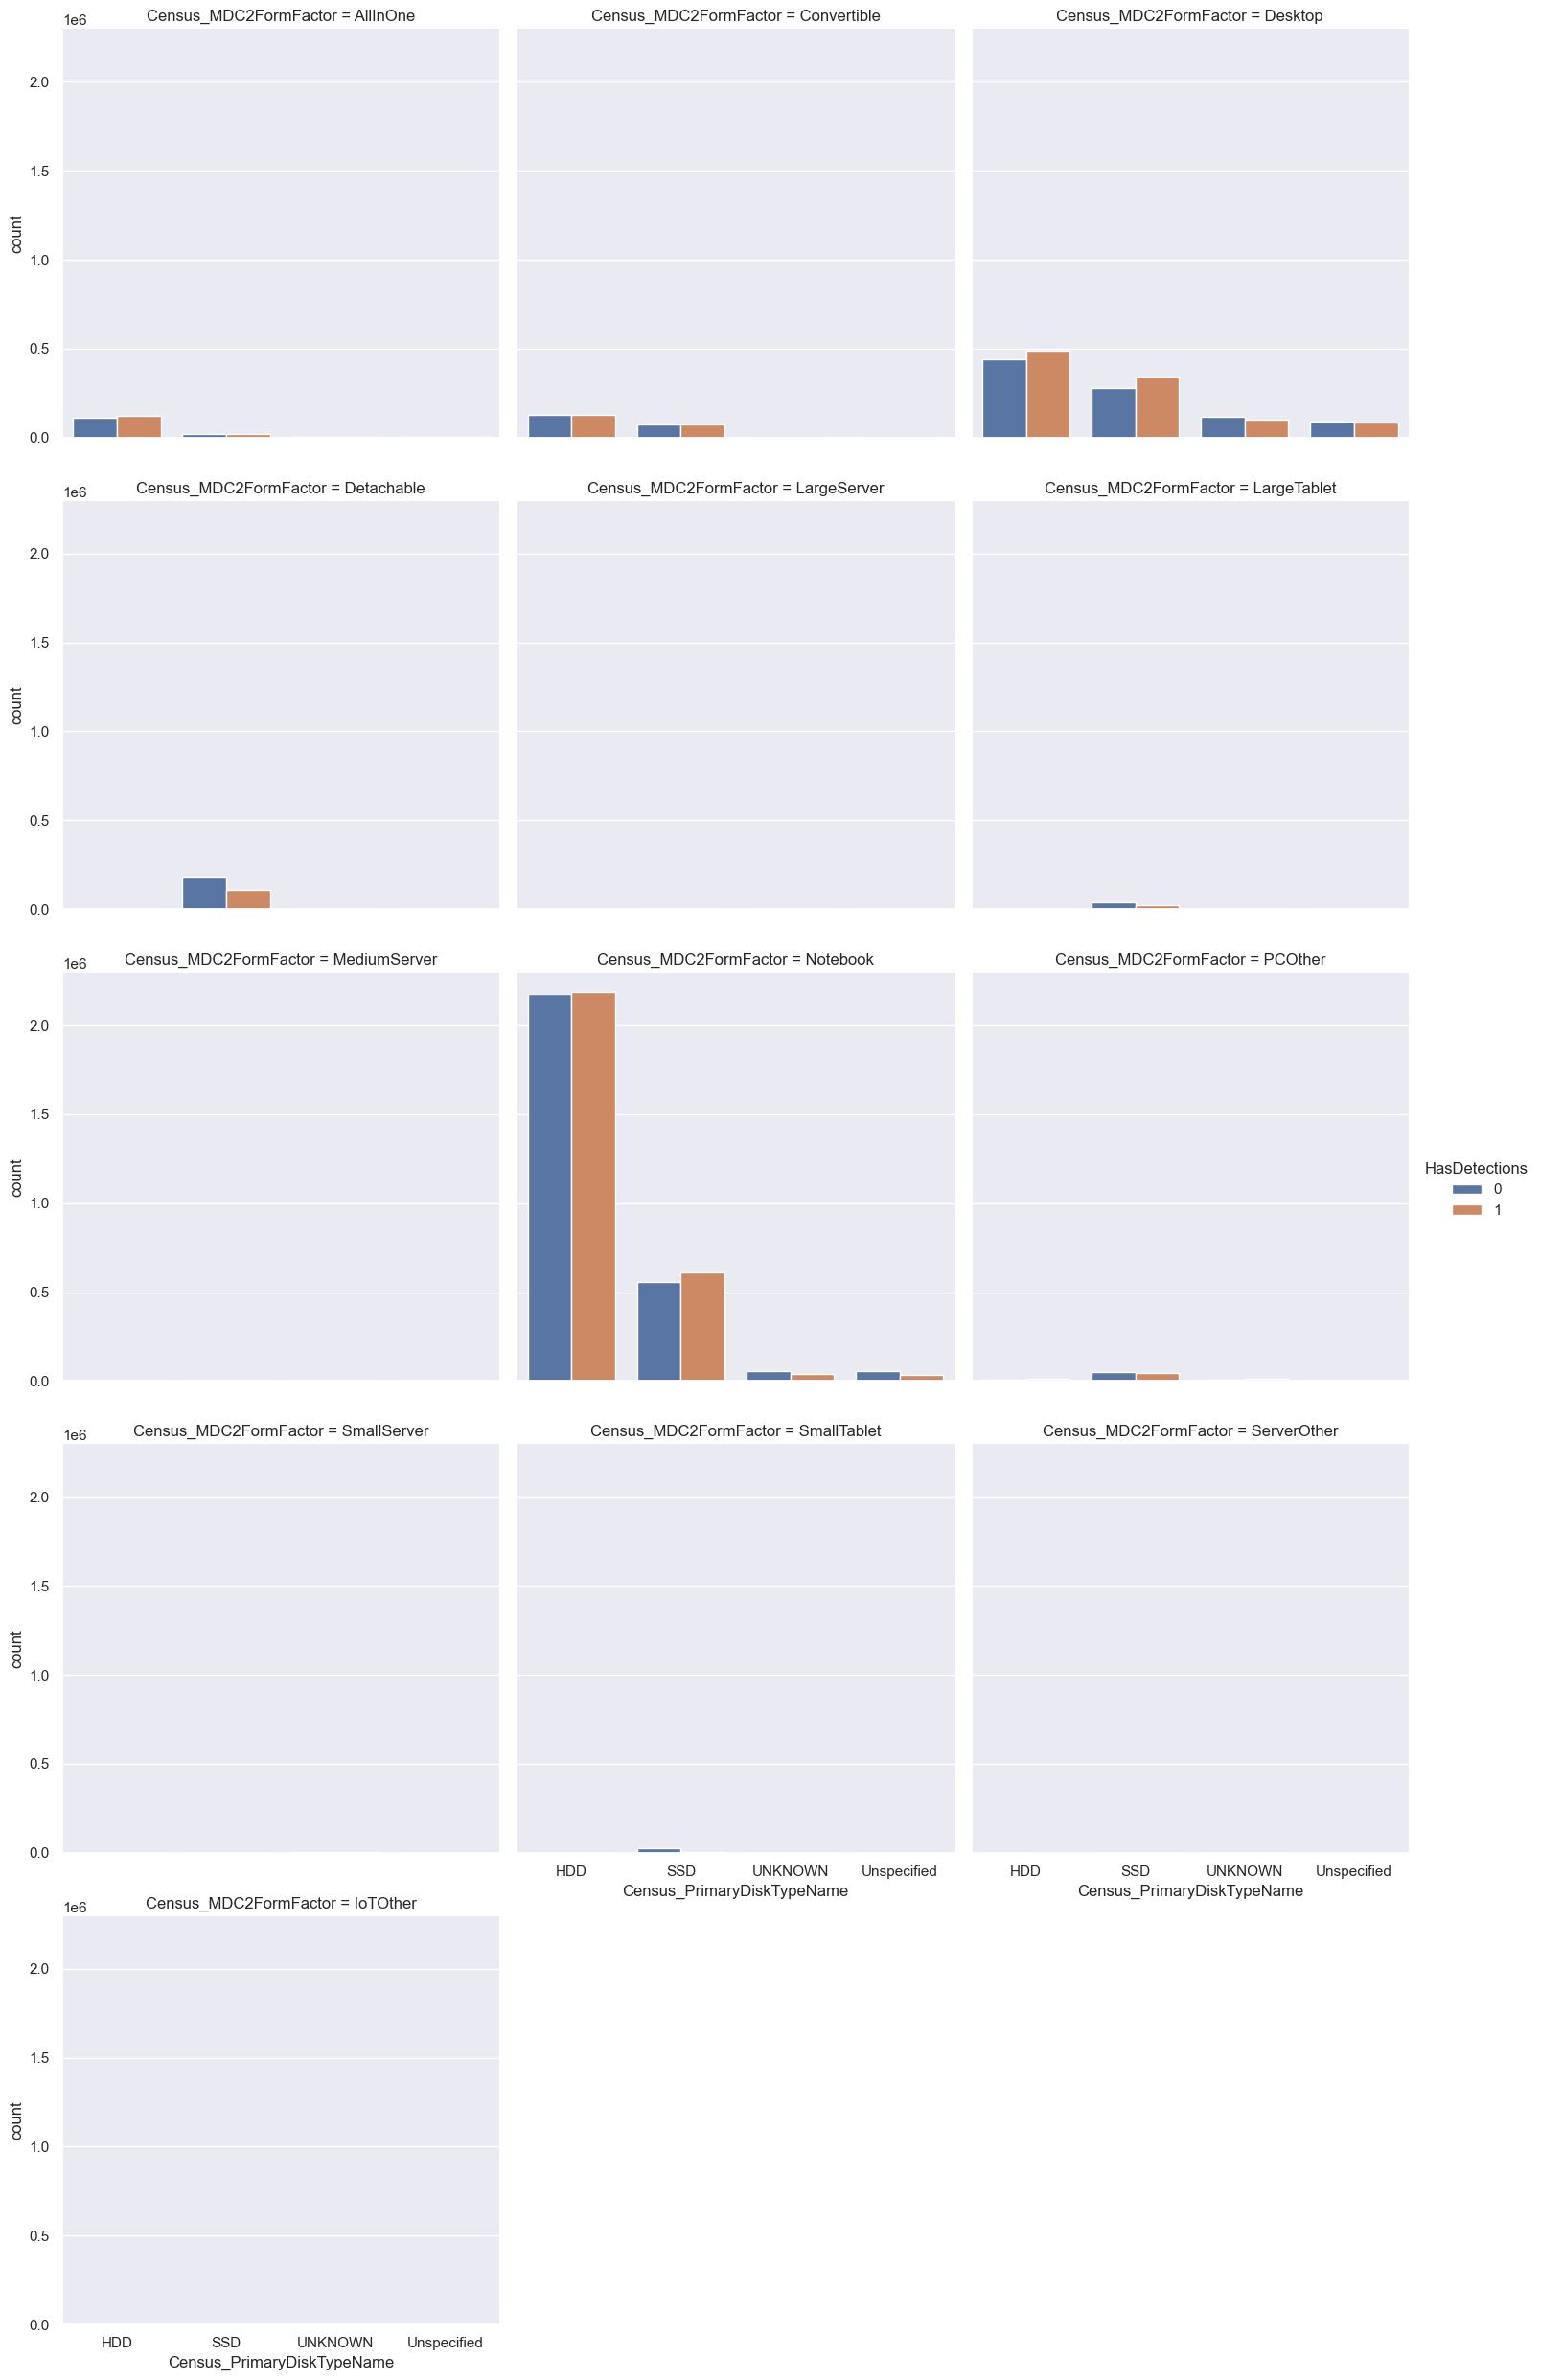

In [92]:
sns.catplot(x="Census_PrimaryDiskTypeName", hue="HasDetections", col="Census_MDC2FormFactor",
                data=train, kind="count",col_wrap=3);

These two variables interact reasonably . Detachable devices usually have SSD , desktop PC have HDD and SDD and Notebooks usually have HDD . 

In [93]:
train['Census_PrimaryDiskTypeName'].value_counts(dropna=False, normalize=True).cumsum()


Census_PrimaryDiskTypeName
HDD            0.650879
SSD            0.927381
UNKNOWN        0.967537
Unspecified    0.998560
NaN            1.000000
Name: proportion, dtype: float64

In [94]:
plot_categorical_feature('Census_ProcessorManufacturerIdentifier', True)


Census_ProcessorManufacturerIdentifier has 7 unique values and type: float16.
Census_ProcessorManufacturerIdentifier
5.0     0.878701
1.0     0.116605
NaN     0.004631
10.0    0.000038
3.0     0.000024
Name: proportion, dtype: float64


Census_PowerPlatformRoleName

In [95]:
train['Census_PowerPlatformRoleName'].value_counts(dropna=False, normalize=True).cumsum()


Census_PowerPlatformRoleName
Mobile               0.693036
Desktop              0.924681
Slate                0.979889
Workstation          0.992183
SOHOServer           0.996425
UNKNOWN              0.998737
EnterpriseServer     0.999532
AppliancePC          0.999982
PerformanceServer    0.999993
NaN                  0.999999
Unspecified          1.000000
Name: proportion, dtype: float64

In [96]:
plot_categorical_feature('Census_PowerPlatformRoleName', True)


Census_PowerPlatformRoleName has 10 unique values and type: category.
Census_PowerPlatformRoleName
Mobile         0.693036
Desktop        0.231645
Slate          0.055208
Workstation    0.012294
SOHOServer     0.004242
Name: proportion, dtype: float64


Census_OSInstallTypeName

In [97]:
plot_categorical_feature('Census_OSInstallTypeName', True)


Census_OSInstallTypeName has 9 unique values and type: category.
Census_OSInstallTypeName
UUPUpgrade    0.292332
IBSClean      0.185029
Update        0.178592
Upgrade       0.140286
Other         0.094168
Name: proportion, dtype: float64


In [105]:
train.to_pickle('train_data.pkl')
test.to_pickle('test_data.pkl')